# Orange Telecom dataset. Predicting propensity to buy new products or services(appetency).
## Case of highly imbalanced data.

link: [https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro](https://www.kdd.org/kdd-cup/view/kdd-cup-2009/Intro)


## Description
Customer Relationship Management (CRM) is a key element of modern marketing strategies. The KDD Cup 2009 offers the opportunity to work on large marketing databases from the French Telecom company Orange to predict the propensity of customers to switch provider (churn), buy new products or services (appetency), or buy upgrades or add-ons proposed to them to make the sale more profitable (up-selling). This project focuses only on predicting appetency.

## Data
The first 190 variables are numerical and the last 40 are categorical. 
The target values (.labels files) have one example per line in the same order as the corresponding data files. The target values are +1 or -1. We refer to examples having +1 (resp. -1) target values as positive (resp. negative) examples.
- Separator tabulation between the values
- There are missing values (consecutive tabulations)


## Table of contents
0. Loading data
1. Cleaning data
2. Looking at the target and class imbalance
3. Machine Learning 
    3.1 Random Forest w/o PCA and resampling
        3.1.1 Random Forest, w/o PCA, Oversampling minority class
        3.1.2 Random Forest, w/o PCA, Undersampling majority class 
        3.1.3 Random Forest, w/o PCA, SMOTE
    3.2 Logistic regression with SMOTE
        3.2.1 Logistic regression with SMOTE, PCA
    3.3 LGBM 
    3.4 XGBoost 
    3.5 CatBoost 
4. Conclusion]

In [111]:
pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [ ]:
import os
import pandas as pd
import numpy as np
import missingno as msn
import pandas_profiling

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, StratifiedKFold
from category_encoders import CountEncoder, OneHotEncoder, TargetEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, f1_score, precision_score, recall_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import catboost as cb

## 0. Loading data

The datafiles refer to matlab .data format, labels and feature data are separate.

In [57]:
path = 'orange_small_train.data'

data = pd.read_csv(os.path.join(path, 'orange_small_train.data'), sep='\t')

In [32]:
data.shape

(50000, 230)

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 230 entries, Var1 to Var230
dtypes: float64(191), int64(1), object(38)
memory usage: 87.7+ MB


In [6]:
label = pd.read_csv(os.path.join(path, 'orange_small_train_appetency.txt'), header = None)

In [7]:
label.columns = ['target']

In [44]:
label.shape

(50000, 1)

In [8]:
label.head(3)

,target
0,-1
1,-1
2,-1


In [58]:
# Adding target
data['target'] = label['target']

## 1. Cleaning data

In [34]:
# Looking at the data - looks like there are a lot of NAs
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.076907,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36,35.0,NaN,1350864.0,NaN,0.0,NaN,NaN,7333.11,NaN,5.0,NaN,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.0,NaN,NaN,168.0,117625.60,NaN,NaN,NaN,NaN,NaN,1175.0,NaN,NaN,NaN,6.0,NaN,720.0,8.0,NaN,NaN,NaN,NaN,NaN,0.0,1212385.0,69134.0,NaN,NaN,NaN,NaN,NaN,185.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,397579.0,NaN,NaN,NaN,1812252.0,NaN,NaN,NaN,NaN,NaN,NaN,142.0,NaN,NaN,38418.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,462.0,NaN,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.408032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,26,0.0,NaN,2872928.0,NaN,3.0,NaN,NaN,151098.90,NaN,25.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,58158.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.0,NaN,NaN,40.0,-356411.60,NaN,NaN,NaN,NaN,NaN,590.0,NaN,NaN,NaN,72.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,4136430.0,357038.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,278334.0,NaN,NaN,NaN,10439160.0,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,238572.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.599658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130,518.0,NaN,1675

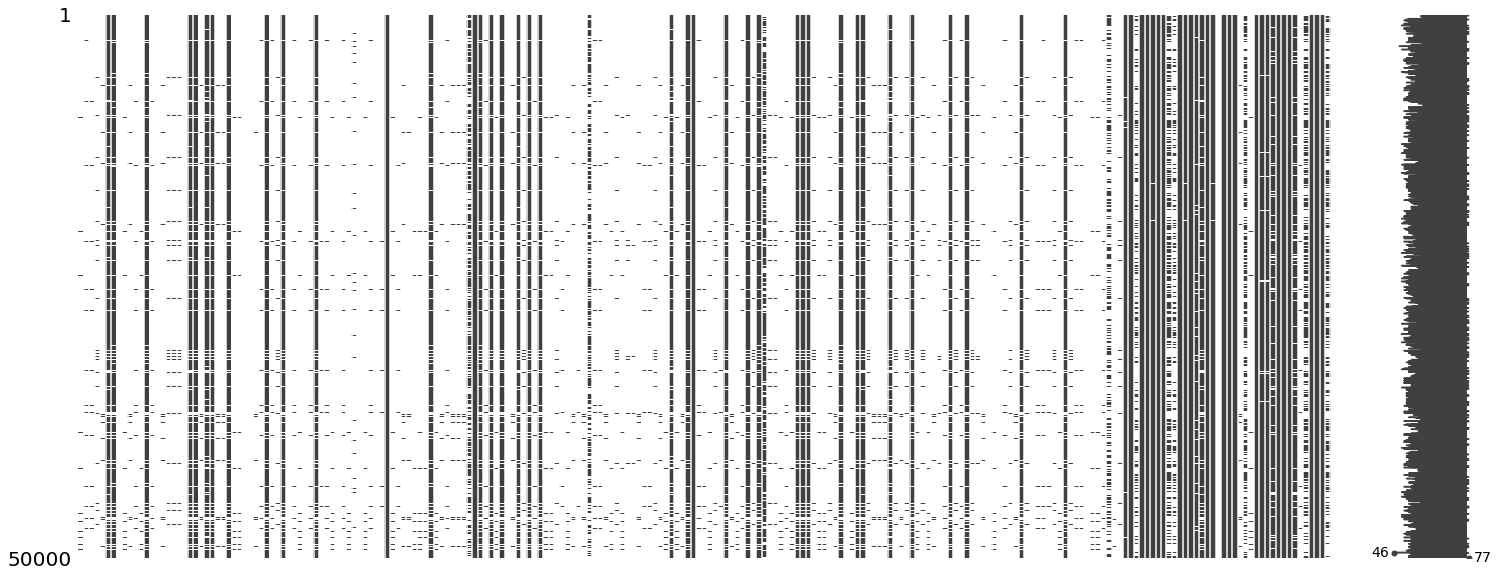

In [36]:
msn.matrix(data);

As we can see there are a lot of missing values - some variables are entirely non-usable, we probably will have to discard them later. There are several features (both categorical and numerical) that seem to practically not have missing values. However, it's clear that the final result will depend on the quality of the preprocessing. 

On another note, as all features are anonimized, it prevents from any qualitative analysis or feature generation based on common sense. Given the sheer amount of the features (mind, that this is a small dataset, original one includes 14,740 variables), it is reasonable to suggest that all the possible features have already been generated before, either using pairwise combinations or other available methods. Thus, we will not focus on feature engeneering in this project.

In [59]:
# Removing all data with NAs more than 30% - those columns can't be used because it will purely be imputed data

columns = data.columns

counter = 0
columns_to_drop = []

for i in columns:
    if data[i].isna().sum()/len(data[i]) >= 0.3:
        print('Eliminating ...%s, percentage missing: %s %%' %(i, round(data[i].isna().sum()*100/len(data[i]), 1)))
        counter +=1
        columns_to_drop.append(i)
              
print('Totally removed %s columns' %counter)
data_cleaned = data.drop(columns_to_drop, axis = 1)

Eliminating ...Var1, percentage missing: 98.6 %
Eliminating ...Var2, percentage missing: 97.5 %
Eliminating ...Var3, percentage missing: 97.5 %
Eliminating ...Var4, percentage missing: 96.8 %
Eliminating ...Var5, percentage missing: 97.0 %
Eliminating ...Var8, percentage missing: 100.0 %
Eliminating ...Var9, percentage missing: 98.6 %
Eliminating ...Var10, percentage missing: 97.0 %
Eliminating ...Var11, percentage missing: 97.5 %
Eliminating ...Var12, percentage missing: 98.9 %
Eliminating ...Var14, percentage missing: 97.5 %
Eliminating ...Var15, percentage missing: 100.0 %
Eliminating ...Var16, percentage missing: 97.0 %
Eliminating ...Var17, percentage missing: 96.8 %
Eliminating ...Var18, percentage missing: 96.8 %
Eliminating ...Var19, percentage missing: 96.8 %
Eliminating ...Var20, percentage missing: 100.0 %
Eliminating ...Var23, percentage missing: 97.0 %
Eliminating ...Var26, percentage missing: 97.0 %
Eliminating ...Var27, percentage missing: 97.0 %
Eliminating ...Var29, pe

As we can see the majority of removed columns didn't have any values at all, they are no use for prediction. However, now we're left with only 68 columns. Let's check missing values there.

In [60]:
(data_cleaned.isna().sum()/data_cleaned.shape[0]).value_counts()

0.10018    20
0.00000    20
0.11078     6
0.11058     6
0.00286     3
0.14460     3
0.01406     2
0.10422     2
0.00738     1
0.00008     1
0.00002     1
0.10022     1
0.03868     1
0.27840     1
dtype: int64

We have one more variable that is almost 30% missing values, 20 with no missing values and 38 with about 10%. We will have to impute those variables. For the one that has 27.8% NAs - let's drop it too.

In [61]:
[data_cleaned.drop(i, axis = 1, inplace = True)  for i in data_cleaned.columns if data_cleaned[i].isna().sum()/data_cleaned.shape[0] > 0.25]

[None]

In [64]:
(data_cleaned.isna().sum()/data_cleaned.shape[0]).value_counts()

0.10018    20
0.00000    20
0.11078     6
0.11058     6
0.00286     3
0.14460     3
0.01406     2
0.10422     2
0.00738     1
0.00008     1
0.00002     1
0.10022     1
0.03868     1
dtype: int64

Let's take a look at correlations and distributions of the variables that are left

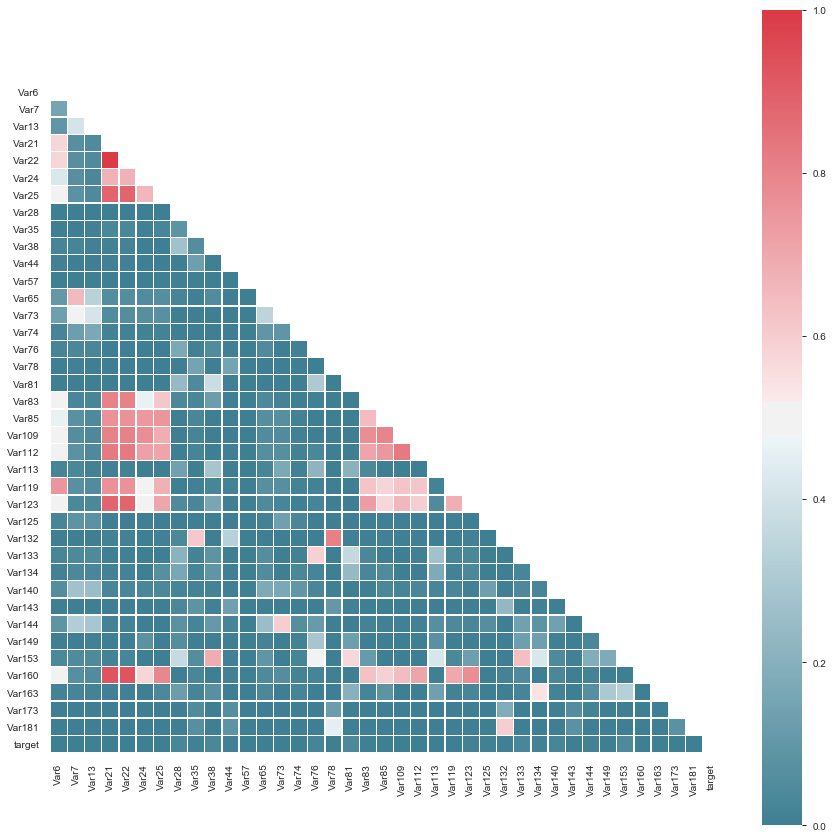

In [80]:
sns.set_style('white')
# Correlation of crimes of different types
corr_df = data_cleaned.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=np.bool))

fig, ax = plt.subplots(figsize = (15, 15))
sns.heatmap(corr_df, cmap = sns.diverging_palette(220, 10, as_cmap=True), vmin=0, vmax=1, linewidths=.3, square = True, mask = mask)

#Adjusting bottom and top rows
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

As we can see, there are some variables that highly correlate with each other. We should drop either of them not to introduce multicollinearity in the model. Another approach might be to use PCA technique to reduce the number of dimentions. Candidates for eliminating given their almost perfect correlation with some other variables:  
- `Var160`
- `Var22`

In [114]:
data_cleaned.groupby('Var65')['Var7'].mean()

Var65
9.0        4.357992
18.0       8.041357
27.0      12.199131
36.0      16.019296
45.0      19.784800
54.0      20.524887
63.0      21.160920
72.0      25.344828
81.0      18.812500
90.0      22.750000
99.0      16.000000
108.0     24.500000
117.0     28.000000
126.0     38.500000
180.0    140.000000
Name: Var7, dtype: float64

In [115]:
# Looking at each variable individually
data_cleaned.isna().sum()/data_cleaned.shape[0]

Var6      0.11058
Var7      0.11078
Var13     0.11078
Var21     0.11058
Var22     0.10018
Var24     0.14460
Var25     0.10018
Var28     0.10022
Var35     0.10018
Var38     0.10018
Var44     0.10018
Var57     0.00000
Var65     0.11078
Var73     0.00000
Var74     0.11078
Var76     0.10018
Var78     0.10018
Var81     0.11058
Var83     0.10018
Var85     0.10018
Var109    0.14460
Var112    0.10018
Var113    0.00000
Var119    0.11058
Var123    0.10018
Var125    0.11078
Var132    0.10018
Var133    0.10018
Var134    0.10018
Var140    0.11078
Var143    0.10018
Var144    0.11058
Var149    0.14460
Var153    0.10018
Var160    0.10018
Var163    0.10018
Var173    0.10018
Var181    0.10018
Var192    0.00738
Var193    0.00000
Var195    0.00000
Var196    0.00000
Var197    0.00286
Var198    0.00000
Var199    0.00008
Var202    0.00002
Var203    0.00286
Var204    0.00000
Var205    0.03868
Var206    0.11058
Var207    0.00000
Var208    0.00286
Var210    0.00000
Var211    0.00000
Var212    0.00000
Var216    

In [195]:
# Casting proper types
data_cleaned['target'] = data_cleaned['target'].astype('category')
for i in data_cleaned.select_dtypes(np.object).columns:
    data_cleaned[i] = data_cleaned[i].astype('category')

In [196]:
#Checking types
data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 67 columns):
Var6      44471 non-null float64
Var7      44461 non-null float64
Var13     44461 non-null float64
Var21     44471 non-null float64
Var22     44991 non-null float64
Var24     42770 non-null float64
Var25     44991 non-null float64
Var28     44989 non-null float64
Var35     44991 non-null float64
Var38     44991 non-null float64
Var44     44991 non-null float64
Var57     50000 non-null float64
Var65     44461 non-null float64
Var73     50000 non-null int64
Var74     44461 non-null float64
Var76     44991 non-null float64
Var78     44991 non-null float64
Var81     44471 non-null float64
Var83     44991 non-null float64
Var85     44991 non-null float64
Var109    42770 non-null float64
Var112    44991 non-null float64
Var113    50000 non-null float64
Var119    44471 non-null float64
Var123    44991 non-null float64
Var125    44461 non-null float64
Var132    44991 non-null float64
Va

## 2. Looking at the target and class imbalance

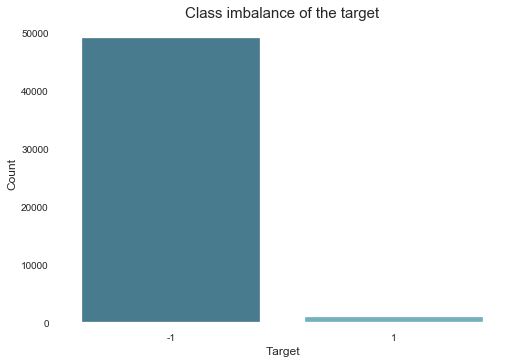

In [109]:
ax = sns.countplot(x = data_cleaned.target, palette = 'GnBu_d')
ax.set_title('Class imbalance of the target', fontsize = 15)
ax.set_xlabel('Target', fontsize = 12)
ax.set_ylabel('Count', fontsize = 12);

In [104]:
print('Total class imbalance is: %s %% negative labels to %s %% positive ones' %(round(sum(data_cleaned.target == -1)*100/len(data_cleaned.target),2), 
                                                round(sum(data_cleaned.target == 1)*100/len(data_cleaned.target),2)))

Total class imbalance is: 98.22 % negative labels to 1.78 % positive ones


In [106]:
# Calculate the weights of the class
compute_class_weight('balanced', np.unique(data_cleaned.target), data_cleaned.target)

array([ 0.50906129, 28.08988764])

The dataset is heavily imbalanced. This can lead to algorithms performing worse if it's not treated properly. Moreover, it's clear that we can't use such metric as accuracy, since it's gonna give us biased perception of the performance of the model (detecting the majority of cases where the person will not buy the new product may result in about 97% accuracy but the model might be very bad at detecting the people we are actually interested in). Thus, extra attention should be paid to confusion matrix/Precision/Recall/F1 score/AUC.

There are several techniques that we can apply to improve model performance with highly imbalanced data:
- Using `class_balance` parameter when running models with calculated weights of the class;  
- Resampling:  
    - Oversampling the minority class  
    - Undersampling the majority class (probably will perform worse since we only have 890 observations of minority class)  
- Generating synthetic samples (SMOTE)

## 3. Machine Learning

### 3.1 Random Forest w/o PCA and resampling

Before machine learning we split the set into test and train. I prefer stratified split given highly imbalanced data.

In [189]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data_cleaned, data_cleaned["target"]):
    strat_train = data_cleaned.loc[train_index]
    strat_test = data_cleaned.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train = strat_train.drop('target', axis = 1)
X_test = strat_test.drop('target', axis = 1)

y_train = strat_train['target']
y_test = strat_test['target']

In [247]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder(handle_unknown=0)),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

rf = RandomForestClassifier()
params_grid = {'max_depth': [4, 5,7, None],
                'n_estimators': [50, 100, 200, 150], 
                'min_samples_leaf': [3, 4, 5]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 234 out of 240 | elapsed:  4.1min remaining:    6.3s
[Parallel(n_jobs=-1)]: Done 240 out 

In [248]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 200}

In [251]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest w/o PCA: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest w/o PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest w/o PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest w/o PCA:  0.9822
Test performance on Random Forest w/o PCA roc_auc:  0.5
Test performance on Random Forest w/o PCA f1-score:  0.0
              precision    recall  f1-score   support

    class_-1       0.98      1.00      0.99      9822
     class_1       0.00      0.00      0.00       178

    accuracy                           0.98     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.96      0.98      0.97     10000



In [254]:
#Checking predictions - we had 10k observations in the test set
predictions = pd.DataFrame(y_pred)
predictions[0].value_counts()

-1    10000
Name: 0, dtype: int64

As we can see, there is a massive overfitting here. We are predicting all the observations as majority class. Let's try resampling.

### 3.1.1 Random Forest, w/o PCA, Oversampling minority class

Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when we don’t have a a lot of data.

It's crucial to remember that we must not conduct any resampling techniques before splitting into test and train since that allows the exact same observations to be present in both the test and train sets. This can allow our model to simply memorize specific data points and cause overfitting and poor generalization to the test data.

In [260]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
didnt_buy = X[X.target==-1]
bought = X[X.target==1]

# upsample minority
bought_upsampled = resample(bought,
                          replace=True, # sample with replacement
                          n_samples=len(didnt_buy), # match number in majority class
                          random_state=27) 

# combine majority and upsampled minority
data_upsampled = pd.concat([didnt_buy, bought_upsampled])

X_train = data_upsampled.drop('target', axis = 1)
y_train = data_upsampled.target

# check new class counts
data_upsampled.target.value_counts()

-1    39288
 1    39288
Name: target, dtype: int64

In [261]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder(handle_unknown=0)),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

rf = RandomForestClassifier()
params_grid = {'max_depth': [4, 5,7, None],
                'n_estimators': [50, 100, 200, 150], 
                'min_samples_leaf': [3,  4, 5]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 113 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 149 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 189 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 234 out of 240 | elapsed:  8.9min remaining:   13.7s
[Parallel(n_jobs=-1)]: Done 240 out 

In [262]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': None, 'min_samples_leaf': 3, 'n_estimators': 50}

In [263]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest w/o PCA: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest w/o PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest w/o PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest w/o PCA:  0.999949093870902
Test performance on Random Forest w/o PCA roc_auc:  0.5078435477339337
Test performance on Random Forest w/o PCA f1-score:  0.0332409972299169
              precision    recall  f1-score   support

    class_-1       0.98      0.98      0.98      9822
     class_1       0.03      0.03      0.03       178

    accuracy                           0.97     10000
   macro avg       0.51      0.51      0.51     10000
weighted avg       0.97      0.97      0.97     10000



The results are still bad but we can see some improvement: now we are predicting that some clients will buy our product.

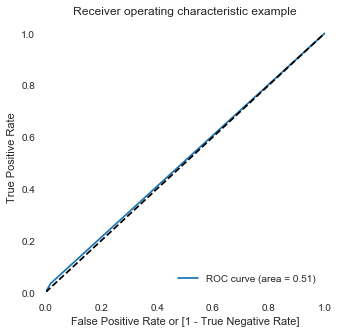

In [264]:
# Plotting roc_curve
def draw_roc(actual, probs):
    fpr, tpr, thresholds = roc_curve(actual, probs, drop_intermediate=False)
    auc_score = roc_auc_score(actual, probs)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, label="ROC curve (area = %0.2f)" % auc_score)
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate or [1 - True Negative Rate]")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic example")
    plt.legend(loc="lower right")
    plt.show()
    return None


fpr, tpr, thresholds = roc_curve(y_test,y_pred,drop_intermediate=False)

draw_roc(y_test, y_pred)

For now, the model's predicting power is very weak: it's close to random.

### 3.1.2 Random Forest, w/o PCA, Undersampling majority class

Undersampling is removing some observations of the majority class. Undersampling can be a good choice when we have a lot of data(which is not the case now). But a crucial drawback is that we are removing information that may be valuable. This could lead to underfitting and poor generalization to the test set. 

We will still be using the separate classes from the previous oversampling exercise.

In [266]:
# downsample majority
didnt_buy_downsampled = resample(didnt_buy,
                                replace = False, # sample without replacement
                                n_samples = len(bought), # match minority n
                                random_state = 27) # reproducible results

# combine minority and downsampled majority
data_downsampled = pd.concat([didnt_buy_downsampled, bought])

# checking counts
data_downsampled.target.value_counts()

X_train = data_downsampled.drop('target', axis = 1)
y_train = data_downsampled.target

# check new class counts
data_downsampled.target.value_counts()

-1    39288
 1    39288
Name: target, dtype: int64

In [278]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder(handle_unknown=0)),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

rf = RandomForestClassifier()

params_grid = {'max_depth': [None],
                'n_estimators': [50, 55,45], 
                'min_samples_leaf': [1,None], 
              'random_state': [42, 27, 901, 926]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   53.1s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 102 out of 120 | elapsed:  1.4min remaining:   15.1s
[Parallel(n_jobs=-1)]: Done 115 out of 120 | elapsed:  1.6min remaining:    4.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.6min finished


In [279]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 1,
 'n_estimators': 50,
 'random_state': 42}

In [280]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest w/o PCA: ',  grid_rf.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest w/o PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest w/o PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest w/o PCA:  1.0
Test performance on Random Forest w/o PCA roc_auc:  0.5018926784402818
Test performance on Random Forest w/o PCA f1-score:  0.01015228426395939
              precision    recall  f1-score   support

    class_-1       0.98      1.00      0.99      9822
     class_1       0.05      0.01      0.01       178

    accuracy                           0.98     10000
   macro avg       0.52      0.50      0.50     10000
weighted avg       0.97      0.98      0.97     10000



The results are worse than with oversampling as expected.

### 3.1.3 Random Forest, w/o PCA, SMOTE

A technique similar to upsampling is SMOTE (Synthetic Minority Oversampling Technique). SMOTE uses a nearest neighbors algorithm to generate new and synthetic data we can use for training our model.
Again, it’s important to generate the new samples only in the training set to ensure our model generalizes well to unseen data.

In [297]:
# using stratified shuffle split from sklean to initiate the split
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state=42)

# writing a loop to stratify by category and store in train test
for train_index, test_index in split.split(data_cleaned, data_cleaned["target"]):
    strat_train = data_cleaned.loc[train_index]
    strat_test = data_cleaned.loc[test_index]
    
## creating the x_train, x_test, y_train & y_test
X_train = strat_train.drop('target', axis = 1)
X_test = strat_test.drop('target', axis = 1)

y_train = strat_train['target']
y_test = strat_test['target']

In [298]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

In [299]:
from imblearn.over_sampling import SMOTE

print("Before OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("Before OverSampling, counts of label '-1': {} \n".format(sum(y_train==-1)))

sm = SMOTE(random_state=42, n_jobs = -1)
X_train_prep_sm, y_train_sm = sm.fit_sample(X_train_prep, y_train)

print('After OverSampling, the shape of train_X: {}'.format(X_train_prep.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train==1)))
print("After OverSampling, counts of label '-1': {}".format(sum(y_train==-1)))

Before OverSampling, counts of label '1': 712
Before OverSampling, counts of label '-1': 39288 

After OverSampling, the shape of train_X: (78576, 66)
After OverSampling, the shape of train_y: (78576,) 

After OverSampling, counts of label '1': 39288
After OverSampling, counts of label '-1': 39288


In [307]:
rf = RandomForestClassifier()
params_grid = {'max_depth': [None],
                'n_estimators': [200,300], 
                'min_samples_leaf': [2,3,4], 
              'random_state': [42, 901]}

grid_rf = GridSearchCV(rf, param_grid = params_grid, cv = StratifiedKFold(n_splits=5), n_jobs = -1,verbose = 10, scoring = 'roc_auc').fit(X_train_prep_sm, y_train_sm)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  36 out of  60 | elapsed:  8.6min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  43 out of  60 | elapsed:  8.7min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  60 | elapsed: 10.7min remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed: 11.7min remaining:   37.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 11.7min finished


In [366]:
# Getting best parameters
grid_rf.best_params_

{'max_depth': None,
 'min_samples_leaf': 2,
 'n_estimators': 300,
 'random_state': 901}

In [367]:
y_pred = grid_rf.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest w/o PCA: ',  grid_rf.best_estimator_.score(X_train_prep_sm, y_train_sm))
print('Test performance on Random Forest w/o PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest w/o PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest w/o PCA:  0.6753334351455915
Test performance on Random Forest w/o PCA roc_auc:  0.6708615604959287
Test performance on Random Forest w/o PCA f1-score:  0.055458055458055454
              precision    recall  f1-score   support

    class_-1       1.00      0.45      0.62      9822
     class_1       0.03      0.89      0.06       178

    accuracy                           0.46     10000
   macro avg       0.51      0.67      0.34     10000
weighted avg       0.98      0.46      0.61     10000



We can see that SMOTE deals with imbalancing the best so far. The recall is 61% which means that the model now can detect 61% of all people who could buy from us. At the same time the model is still bad with predicting relevant observations - precision is low.

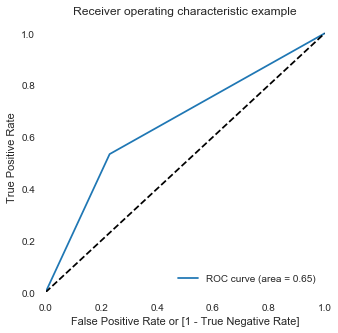

In [310]:
#Roc curve
draw_roc(y_test, y_pred)

## 3.2 Logistic regression with SMOTE

In [377]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

sm = SMOTE(random_state=42, n_jobs = -1)
X_train_prep_sm, y_train_sm = sm.fit_sample(X_train_prep, y_train)

params_grid = {
    'C': np.linspace(1, 10, 10),
    'random_state': [42, 901]
    }

logit = LogisticRegression()
grid_logit = GridSearchCV(logit, param_grid = params_grid, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1, scoring = 'roc_auc').fit(X_train_prep_sm, y_train_sm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   26.6s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   42.0s
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:   42.9s remaining:   10.7s
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:   50.0s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   51.7s finished


In [378]:
# Getting best parameters
grid_logit.best_params_

{'C': 6.0, 'random_state': 42}

In [379]:
y_pred = grid_logit.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest w/o PCA: ',  grid_logit.best_estimator_.score(X_train_prep_sm, y_train_sm))
print('Test performance on Random Forest w/o PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest w/o PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest w/o PCA:  0.7260995723885155
Test performance on Random Forest w/o PCA roc_auc:  0.6968545732007257
Test performance on Random Forest w/o PCA f1-score:  0.07310108509423187
              precision    recall  f1-score   support

    class_-1       0.99      0.67      0.80      9822
     class_1       0.04      0.72      0.07       178

    accuracy                           0.68     10000
   macro avg       0.52      0.70      0.44     10000
weighted avg       0.98      0.68      0.79     10000



Test roc_auc is better than Random Forest, f1_scores are more or less the same. Let's check the performance of the same model without any correction of the imbalance.

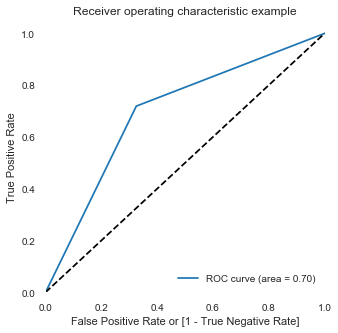

In [345]:
#Roc curve
draw_roc(y_test, y_pred)

**Baseline Logistic Regression**

In [334]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler())
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

params_grid = {
    'C': np.linspace(1, 10, 10),
    'random_state': [42, 901]
    }

logit = LogisticRegression()
grid_logit = GridSearchCV(logit, param_grid = params_grid, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1).fit(X_train_prep, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:   10.7s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:   22.5s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:   26.2s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   26.9s finished


In [335]:
# Getting best parameters
grid_logit.best_params_

{'C': 3.0, 'random_state': 42}

In [336]:
y_pred = grid_logit.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest w/o PCA: ',  grid_logit.best_estimator_.score(X_train_prep, y_train))
print('Test performance on Random Forest w/o PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest w/o PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest w/o PCA:  0.982225
Test performance on Random Forest w/o PCA roc_auc:  0.5
Test performance on Random Forest w/o PCA f1-score:  0.0
              precision    recall  f1-score   support

    class_-1       0.98      1.00      0.99      9822
     class_1       0.00      0.00      0.00       178

    accuracy                           0.98     10000
   macro avg       0.49      0.50      0.50     10000
weighted avg       0.96      0.98      0.97     10000



In [340]:
print('Precision: %s' %precision_score(y_test, y_pred))
print('Recall: %s' %recall_score(y_test, y_pred))

Precision: 0.0
Recall: 0.0


As we can see SMOTE makes a massive difference. Now, let's experiment with PCA, automatic feature generation, scalers and encoders.

### 3.2.1 Logistic regression with SMOTE, PCA

In [346]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()), 
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

In [355]:
# Choosing number of components
pca = PCA()
pca.fit(X_train_prep)
pca.explained_variance_ratio_.cumsum()

array([0.13434992, 0.24712536, 0.30247637, 0.34503459, 0.38499407,
       0.42078583, 0.45158949, 0.47716361, 0.50122618, 0.52307489,
       0.54419828, 0.56436001, 0.58366332, 0.60231359, 0.61964897,
       0.63653792, 0.65278362, 0.66869512, 0.6838879 , 0.69886071,
       0.71368218, 0.72791793, 0.74192603, 0.75548927, 0.76867752,
       0.7814642 , 0.7936797 , 0.80572391, 0.81713359, 0.82816578,
       0.83909168, 0.8495223 , 0.85969914, 0.86953886, 0.87917138,
       0.88867478, 0.89785034, 0.90649365, 0.91470704, 0.92265357,
       0.9298501 , 0.93690444, 0.9438107 , 0.9505488 , 0.95599535,
       0.96120688, 0.96616082, 0.97043658, 0.97456633, 0.97851433,
       0.98215583, 0.98547316, 0.98835897, 0.99055597, 0.99272787,
       0.99466481, 0.99659068, 0.99811814, 0.99961452, 0.99983876,
       0.99993546, 1.        , 1.        , 1.        , 1.        ,
       1.        ])

In [356]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=38))
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

sm = SMOTE(random_state=42, n_jobs = -1)
X_train_prep_sm, y_train_sm = sm.fit_sample(X_train_prep, y_train)



params_grid = {
    'C': np.linspace(1, 10, 10),
    'random_state': [42, 901]
    }

logit = LogisticRegression()
grid_logit = GridSearchCV(logit, param_grid = params_grid, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1).fit(X_train_prep_sm, y_train_sm)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done  80 out of 100 | elapsed:   10.5s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done  91 out of 100 | elapsed:   11.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.8s finished


In [357]:
# Getting best parameters
grid_logit.best_params_

{'C': 2.0, 'random_state': 42}

In [359]:
y_pred = grid_logit.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest with PCA: ',  grid_logit.best_estimator_.score(X_train_prep_sm, y_train_sm))
print('Test performance on Random Forest with PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest with PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest with PCA:  0.7206017104459377
Test performance on Random Forest with PCA roc_auc:  0.5676422340126155
Test performance on Random Forest with PCA f1-score:  0.05003523608174771
              precision    recall  f1-score   support

    class_-1       0.99      0.74      0.84      9822
     class_1       0.03      0.40      0.05       178

    accuracy                           0.73     10000
   macro avg       0.51      0.57      0.45     10000
weighted avg       0.97      0.73      0.83     10000



The results got worse.

## 3.3 LGBM

In [414]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

sm = SMOTE(random_state=42, n_jobs = -1)
X_train_prep_sm, y_train_sm = sm.fit_sample(X_train_prep, y_train)


lgb_params ={ "objective" : ["binary"],
    "metric" : ["auc"],
    "max_depth" : [-1],
    "num_leaves" : [150, 200],
    "learning_rate" : [0.1],
    #"bagging_freq": [2,5],
   # "bagging_fraction" : 0.4,
    #"feature_fraction" : 0.05,
    "min_data_in_leaf": [30,40],
    "lambda_l1" : [40,30],
    "random_state": [901]} 
lgb_clf = lgb.LGBMClassifier()
grid_lgb = GridSearchCV(lgb_clf, param_grid = lgb_params, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1, scoring = 'roc_auc').fit(X_train_prep_sm, y_train_sm)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  14 out of  40 | elapsed:   11.9s remaining:   22.2s
[Parallel(n_jobs=-1)]: Done  19 out of  40 | elapsed:   21.3s remaining:   23.5s
[Parallel(n_jobs=-1)]: Done  24 out of  40 | elapsed:   22.2s remaining:   14.8s
[Parallel(n_jobs=-1)]: Done  29 out of  40 | elapsed:   22.9s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:   27.5s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   28.3s finished


In [415]:
# Getting best parameters
grid_lgb.best_params_

{'lambda_l1': 30,
 'learning_rate': 0.1,
 'max_depth': -1,
 'metric': 'auc',
 'min_data_in_leaf': 30,
 'num_leaves': 150,
 'objective': 'binary',
 'random_state': 901}

In [416]:
y_pred = grid_lgb.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest with PCA: ',  grid_lgb.best_estimator_.score(X_train_prep_sm, y_train_sm))
print('Test performance on Random Forest with PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest with PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest with PCA:  0.9909132559560171
Test performance on Random Forest with PCA roc_auc:  0.6337029461493231
Test performance on Random Forest with PCA f1-score:  0.0474062034403359
              precision    recall  f1-score   support

    class_-1       1.00      0.28      0.44      9822
     class_1       0.02      0.98      0.05       178

    accuracy                           0.30     10000
   macro avg       0.51      0.63      0.24     10000
weighted avg       0.98      0.30      0.44     10000



## 3.4 XGBoost

In [424]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

sm = SMOTE(random_state=42, n_jobs = -1)
X_train_prep_sm, y_train_sm = sm.fit_sample(X_train_prep, y_train)


xgb_params ={ 'max_depth': [20, 40],
    'learning_rate': [0.1,],   
    "random_state": [901]} 
xgb_clf = xgb.XGBClassifier()
grid_xgb = GridSearchCV(xgb_clf, param_grid = xgb_params, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1, scoring = 'roc_auc').fit(X_train_prep_sm, y_train_sm)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:  3.1min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:  3.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:  3.4min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  3.5min finished


In [425]:
# Getting best parameters
grid_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 20, 'random_state': 901}

In [426]:
y_pred = grid_xgb.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest with PCA: ',  grid_xgb.best_estimator_.score(X_train_prep_sm, y_train_sm))
print('Test performance on Random Forest with PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest with PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest with PCA:  1.0
Test performance on Random Forest with PCA roc_auc:  0.6581035693776183
Test performance on Random Forest with PCA f1-score:  0.05474921918059894
              precision    recall  f1-score   support

    class_-1       0.99      0.48      0.65      9822
     class_1       0.03      0.84      0.05       178

    accuracy                           0.49     10000
   macro avg       0.51      0.66      0.35     10000
weighted avg       0.98      0.49      0.64     10000



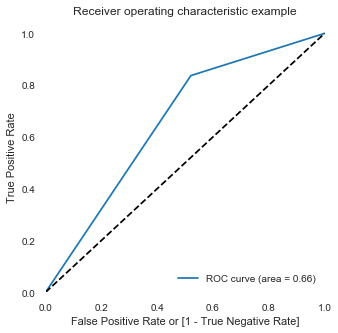

In [430]:
#Roc curve
draw_roc(y_test, y_pred)

## 3.5 CatBoost

In [ ]:
transformation_pipeline = Pipeline([
    ('count_encoder', CountEncoder()),
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()),
])

X_train_prep = transformation_pipeline.fit_transform(X_train)

sm = SMOTE(random_state=42, n_jobs = -1)
X_train_prep_sm, y_train_sm = sm.fit_sample(X_train_prep, y_train)

cat_params ={ "loss_function": ["Logloss"],
                           "eval_metric": ["AUC"],
                           "learning_rate" : [0.01],
                           "iterations" :[7000, 30000],
                            "l2_leaf_reg" : [50],
                           "random_seed": [42],
                           "od_type": ["Iter"],
                           "depth": [5, 20]}
cat_clf = cb.CatBoostClassifier()
grid_cat = GridSearchCV(cat_clf, param_grid = cat_params, cv=StratifiedKFold(n_splits=5), verbose=10, n_jobs=-1, scoring = 'roc_auc').fit(X_train_prep_sm, y_train_sm)

In [431]:
# Getting best parameters
grid_cat.best_params_

{'depth': 5,
 'eval_metric': 'AUC',
 'iterations': 7000,
 'l2_leaf_reg': 50,
 'learning_rate': 0.01,
 'loss_function': 'Logloss',
 'od_type': 'Iter',
 'random_seed': 42}

In [432]:
y_pred = grid_cat.best_estimator_.predict(transformation_pipeline.fit_transform(X_test))

print('Train performance on Random Forest with PCA: ',  grid_cat.best_estimator_.score(X_train_prep_sm, y_train_sm))
print('Test performance on Random Forest with PCA roc_auc: ',roc_auc_score(y_test, y_pred))
print('Test performance on Random Forest with PCA f1-score: ', f1_score(y_test, y_pred))

target_names = ['class_-1', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

Train performance on Random Forest with PCA:  0.9908241702300957
Test performance on Random Forest with PCA roc_auc:  0.5206913395518888
Test performance on Random Forest with PCA f1-score:  0.03644694366343851
              precision    recall  f1-score   support

    class_-1       0.99      0.06      0.11      9822
     class_1       0.02      0.98      0.04       178

    accuracy                           0.07     10000
   macro avg       0.51      0.52      0.07     10000
weighted avg       0.98      0.07      0.11     10000



## 4. Conclusion <a id=cat>

Resampling techniques were extremely important in modelling churn. Imbalance was stark - there were only 2.8% of the positive labels. Because of that all baseline models performed extremely poorly - AUC was 0.5, recall and precision were 0, the model was determining all the test observations as people from the majority class. 

In terms of the dealing with the imbalance the efficiency was the following:
- adding class_weights (did not change the performance, AUC - 0.5);
- oversampling the minority class (improved the performance slightly, AUC - 0.5018);
- undersampling the majority class(improved the performance slightly, AUC - 0.5078);
- SMOTE (improved the performance significantly, AUC - 0.67086)

In terms of the classifiers the best performance was achieved by the simplest Logit (AUC - 0.6969), then RandomForest (AUC - 0.6709), XGBoost (AUC - 0.6581). Given that initial dataset had the majority of columns with all the data missing, it might explain such low metrics.

PCA and MinMaxScaler did not achieve high results as well.